In [2]:
!pip install jieba

In [3]:
import requests
from bs4 import BeautifulSoup
import re
import jieba
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
url = "https://zh.wikipedia.org/zh-tw/Seventeen%E6%BC%94%E5%94%B1%E6%9C%83%E5%88%97%E8%A1%A8"
headers = {
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
}

res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

# 演唱會目錄

In [108]:
final_df = pd.DataFrame(columns=['日期', '國家／地區', '城市', '舉行地點','備註'])
processed_df = []

# 逐一處理每個表格
for i, table in enumerate(tables):
    # 檢查索引是否在需要刪除的範圍內
    if i + 1 in [11, 12, 13]:
        continue  # 跳過不處理

    # 提取表格的數據
    rows = table.find_all("tr")
    data = []

    for row in rows:
        cols = row.find_all(["th", "td"])
        cols = [col.get_text(strip=True) for col in cols]
        data.append(cols)
        

    # 將數據轉換成 DataFrame
    df = pd.DataFrame(data[1:], columns=data[0])
    
    # 進行資料清理和轉換
    df['日期'] = df['日期'].apply(lambda x: None if len(str(x)) > 11 else x)

    # 刪除 '日期' 列中值為 None 或 NaN 的行
    df.dropna(subset=['日期'], inplace=True)
    
    # 找到['舉行地點']為None的行
    mask = df['舉行地點'].isnull()
    
    # 用 shift 方法將指定的列向右移
    df.loc[mask, ['國家／地區', '城市', '舉行地點']] = df.loc[mask, ['國家／地區', '城市', '舉行地點']].shift(axis=1)
    
    # 將['國家／地區']中特定的值替換為None
    df['國家／地區'].replace({'特定值': None}, inplace=True)
    
    #若['國家／地區']和['舉行地點']皆為None，['城市']也改為None
    df['城市'] = df.apply(lambda row: None if row['國家／地區'] is None and row['舉行地點'] is None else row['城市'], axis=1)
    
    rows_to_shift = [5, 8, 10, 17, 18, 19, 20, 21, 22, 23] 
    if i + 1 in [9]:
        for row_index in rows_to_shift:
            df.loc[row_index, ['國家／地區', '城市', '舉行地點', '備註']] = df.loc[row_index, ['國家／地區', '城市', '舉行地點', '備註']].shift(1)
    
     # 刪除 "備註 "這列
    if '備註' in df.columns:
        df = df.drop(columns=['備註'])
    
    #補None的值
    for column in df.columns:
        first_non_none_value = df[column].dropna().iloc[0]  # 找到每一列中第一個非 None 的值
        df[column] = df[column].fillna(first_non_none_value)  # 用每一列中第一個非 None 的值填補後面的 None

    # 將處理後的 DataFrame 添加到列表中
    processed_df.append(df)

# 使用 concat 方法將所有 DataFrame 合併
final_df = pd.concat(processed_df, ignore_index=True)

# 打印或使用 final_df 中的 DataFrame
print(final_df)

              日期 國家／地區   城市        舉行地點
0    2015年12月24日    南韓   首爾  龍山ART HALL
1    2015年12月25日    南韓   首爾  龍山ART HALL
2    2015年12月26日    南韓   首爾  龍山ART HALL
3     2016年7月30日    南韓   首爾   首爾蠶室室內體育館
4     2016年7月31日    南韓   首爾   首爾蠶室室內體育館
..           ...   ...  ...         ...
149  2023年12月24日    泰國   曼谷    拉加曼加拉體育場
150   2024年1月13日   菲律賓  布拉干      菲律賓體育館
151   2024年1月14日    泰國   曼谷    拉加曼加拉體育場
152   2024年1月20日    澳門   澳門    奧林匹克體育中心
153   2024年1月21日    泰國   曼谷    拉加曼加拉體育場

[154 rows x 4 columns]


In [114]:
# 計算國家／地區次數
city_counts = final_df['國家／地區'].value_counts(dropna=False)

# 打印國家／地區次數
print("國家／地區:\n", city_counts)

國家／地區:
 南韓       62
日本       49
泰國        7
菲律賓       6
印度尼西亞     5
美國        4
加拿大       3
馬來西亞      3
新加坡       3
臺灣        3
中國        2
智利        1
東京        1
西班牙       1
法國        1
英國        1
德國        1
澳門        1
Name: 國家／地區, dtype: int64


In [113]:
# 計算城市次數
city_counts = final_df['城市'].value_counts(dropna=False)

# 打印城市次數
print("城市:\n", city_counts)

城市:
 首爾        41
東京        10
福岡        10
埼玉         9
曼谷         7
大阪         7
橫濱         6
神戶         5
雅加達        5
馬尼拉        4
吉隆坡        3
新加坡        3
布拉干        2
西雅圖        2
台北         2
芝加哥        2
千葉         2
休斯頓        2
愛知         2
香港         2
紐約         2
多倫多        2
達拉斯        2
名古屋        1
中野太陽廣場     1
愛知縣        1
紐華克        1
亞特蘭大       1
華盛頓        1
沃斯堡        1
洛杉磯        1
奧克蘭        1
溫哥華        1
倫敦         1
柏林         1
靜岡         1
巴黎         1
馬德里        1
聖荷西        1
美國         1
墨西哥        1
紐澤西        1
聖地亞哥       1
臺北         1
澳門         1
Name: 城市, dtype: int64


In [157]:
japan_cities = final_df[final_df['國家／地區'] == '日本']['城市'].value_counts(dropna=False)

# 打印城市次數
print("城市:\n", japan_cities)

城市:
 福岡     10
埼玉      9
東京      9
大阪      7
神戶      5
橫濱      5
名古屋     1
靜岡      1
千葉      1
愛知      1
Name: 城市, dtype: int64


# 圖表一


In [111]:
!pip install folium

  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/a2/1a/37c7ee1bc806d6c32621fecc72c19f6a9f9b4369e5e8f406a7c16d49f031/folium-0.15.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/2f/e7/603b136221de923055716d23e3047da71f92e0d8ba2c4517ce49a54fe768/branca-0.7.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/100.3 kB ? eta -:--:--
   ------------ --------------------------- 30.7/100.3 kB 1.4 MB/s eta 0:00:01
   ----------------------- --------------- 61.4/100.3 kB 825.8 kB/s eta 0:00:01
   ---------------------------------------- 100.3/100.3 kB 1.2 MB/s eta 0:00:00


In [118]:
import folium
from folium.plugins import HeatMap

In [119]:
#創建世界地圖
m = folium.Map(location=[0, 0], zoom_start=2)

In [121]:
locations = {
    '南韓': {'lat': 37.5665, 'lon': 126.9780},  # 南韓的首爾
    '日本': {'lat': 35.6895, 'lon': 139.6917},  # 日本的東京
    '泰國': {'lat': 13.7563, 'lon': 100.5018},  # 泰國的曼谷
    '菲律賓': {'lat': 14.5995, 'lon': 120.9842},  # 菲律賓的馬尼拉
    '印度尼西亞': {'lat': -6.2088, 'lon': 106.8456},  # 印尼的雅加達
    '美國': {'lat': 40.7128, 'lon': -74.0060},  # 美國的紐約
    '加拿大': {'lat': 45.4215, 'lon': -75.6972},  # 加拿大的渥太華
    '馬來西亞': {'lat': 3.1390, 'lon': 101.6869},  # 馬來西亞的吉隆坡
    '新加坡': {'lat': 1.3521, 'lon': 103.8198},  # 新加坡的新加坡市
    '臺灣': {'lat': 25.0330, 'lon': 121.5654},  # 臺灣的台北
    '中國': {'lat': 39.9042, 'lon': 116.4074},  # 中國的北京
    '智利': {'lat': -33.4489, 'lon': -70.6693},  # 智利的聖地亞哥
    '西班牙': {'lat': 40.4168, 'lon': -3.7038},  # 西班牙的馬德里
    '法國': {'lat': 48.8566, 'lon': 2.3522},  # 法國的巴黎
    '英國': {'lat': 51.5074, 'lon': -0.1278},  # 英國的倫敦
    '德國': {'lat': 52.5200, 'lon': 13.4050},  # 德國的柏林
    '澳門': {'lat': 22.1987, 'lon': 113.5439}  # 澳門
}

In [123]:
word_freq = {
    '南韓': 62,
    '日本': 49,
    '泰國': 7,
    '菲律賓': 6,
    '印度尼西亞': 5,
    '美國': 4,
    '加拿大': 3,
    '馬來西亞': 3,
    '新加坡': 3,
    '臺灣': 3,
    '中國': 2,
    '智利': 1,
    '西班牙': 1,
    '法國': 1,
    '英國': 1,
    '德國': 1,
    '澳門': 1
}

In [125]:
# 創建用於HeatMap的數據點
heat_data = []

for location, info in locations.items():
    # 使用 place 作為鍵來檢索重複次數
    count = word_freq.get(location, 0)  # 如果未找到該景點，默認重複次數為 0
    if count > 0:  # 只有當重複次數大於0時才添加到熱點數據
        heat_data.append([info['lat'], info['lon'], count])

# 創建熱點圖層
HeatMap(heat_data).add_to(m)


# 顯示地圖
m

# 圖表二

In [127]:
!pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/3e/cf/ede993ed7070c5487e6db550aad490178c06eaa48ad26ff5e5263f995fba/geopandas-0.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for fiona>=1.8.21 from https://files.pythonhosted.org/packages/7f/27/b24c1610c7ae5716709321f04d38d7b8b71ed531f80df4f697b9ad99cfc3/fiona-1.9.5-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/51.1 kB ? eta -:--:--
     ------------------------------ ------- 41.0/51.1 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 51.1/51.1 kB 659.2 kB/s eta 0:00:00
  Obtaining dependency information for pyproj>=3.3.0 from https://files.pythonhosted.org/packages/79/95/eb68113c5b5737c342bde1bab92705dabe69c16299c5a122616e50f1fbd6/pyproj-3.6.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for shapely>=1.8.0 from https://files.pythonhosted.org/packages/9e/39/029c441d8af32ab423b229c4525ce5ce67

In [144]:
import geopandas
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

In [148]:
city_data = {
    '首爾': 41,
    '東京': 10,
    '福岡': 10,
    '埼玉': 9,
    '曼谷': 7,
    '大阪': 7,
    '橫濱': 6,
    '神戶': 5,
    '雅加達': 5,
    '馬尼拉': 4,
    '吉隆坡': 3,
    '新加坡': 3,
    '布拉干': 2,
    '西雅圖': 2,
    '臺北': 2,
    '芝加哥': 2,
    '千葉': 2,
    '休斯頓': 2,
    '愛知': 2,
    '香港': 2,
    '紐約': 2,
    '多倫多': 2,
    '達拉斯': 2,
    '名古屋': 1,
    '中野太陽廣場': 1,
    '愛知縣': 1,
    '紐華克': 1,
    '亞特蘭大': 1,
    '華盛頓': 1,
    '沃斯堡': 1,
    '洛杉磯': 1,
    '奧克蘭': 1,
    '溫哥華': 1,
    '倫敦': 1,
    '柏林': 1,
    '靜岡': 1,
    '巴黎': 1,
    '馬德里': 1,
    '聖荷西': 1,
    '美國': 1,
    '墨西哥': 1,
    '紐澤西': 1,
    '聖地亞哥': 1,
    '臺北': 1,
    '澳門': 1
}


In [149]:
city_locations = {
    '首爾': {'lat': 37.5665, 'lon': 126.9780},
    '東京': {'lat': 35.6895, 'lon': 139.6917},
    '福岡': {'lat': 33.5904, 'lon': 130.4017},
    '埼玉': {'lat': 35.8617, 'lon': 139.6452},
    '曼谷': {'lat': 13.7563, 'lon': 100.5018},
    '大阪': {'lat': 34.6937, 'lon': 135.5023},
    '橫濱': {'lat': 35.4437, 'lon': 139.6380},
    '神戶': {'lat': 34.6913, 'lon': 135.1830},
    '雅加達': {'lat': -6.2088, 'lon': 106.8456},
    '馬尼拉': {'lat': 14.5995, 'lon': 120.9842},
    '吉隆坡': {'lat': 3.139, 'lon': 101.6869},
    '新加坡': {'lat': 1.3521, 'lon': 103.8198},
    '布拉干': {'lat': -15.8270, 'lon': -47.9228},
    '西雅圖': {'lat': 47.6062, 'lon': -122.3321},
    '臺北': {'lat': 25.0330, 'lon': 121.5654},
    '芝加哥': {'lat': 41.8781, 'lon': -87.6298},
    '千葉': {'lat': 35.6073, 'lon': 140.1063},
    '休斯頓': {'lat': 29.7604, 'lon': -95.3698},
    '愛知': {'lat': 35.1802, 'lon': 136.9066},
    '香港': {'lat': 22.3193, 'lon': 114.1694},
    '紐約': {'lat': 40.7128, 'lon': -74.0060},
    '多倫多': {'lat': 43.65107, 'lon': -79.347015},
    '達拉斯': {'lat': 32.7767, 'lon': -96.7970},
    '名古屋': {'lat': 35.1815, 'lon': 136.9066},
    '中野太陽廣場': {'lat': 35.7058, 'lon': 139.6651},
    '愛知縣': {'lat': 35.0038, 'lon': 137.2165},
    '紐華克': {'lat': 40.7357, 'lon': -74.1724},
    '亞特蘭大': {'lat': 33.7490, 'lon': -84.3880},
    '華盛頓': {'lat': 38.9072, 'lon': -77.0369},
    '沃斯堡': {'lat': 32.7555, 'lon': -97.3308},
    '洛杉磯': {'lat': 34.0522, 'lon': -118.2437},
    '奧克蘭': {'lat': 37.8044, 'lon': -122.2711},
    '溫哥華': {'lat': 49.2827, 'lon': -123.1207},
    '倫敦': {'lat': 51.5074, 'lon': -0.1278},
    '柏林': {'lat': 52.5200, 'lon': 13.4050},
    '靜岡': {'lat': 34.9756, 'lon': 138.3828},
    '巴黎': {'lat': 48.8566, 'lon': 2.3522},
    '馬德里': {'lat': 40.4168, 'lon': -3.7038},
    '聖荷西': {'lat': 37.3382, 'lon': -121.8863},
    '美國': {'lat': 37.0902, 'lon': -95.7129},
    '墨西哥': {'lat': 23.6345, 'lon': -102.5528},
    '紐澤西': {'lat': 40.0583, 'lon': -74.4057},
    '聖地亞哥': {'lat': 32.7157, 'lon': -117.1611},
    '澳門': {'lat': 22.1987, 'lon': 113.5439}
}


In [151]:
geometry = [Point(city_locations[city]['lon'], city_locations[city]['lat']) for city in city_data]
gdf = gpd.GeoDataFrame(city_data, geometry=geometry, columns=['出現次數'])
# 設置 '出現次數' 列
gdf['出現次數'] = gdf.index


print(gdf)

    出現次數                     geometry
0      0   POINT (126.97800 37.56650)
1      1   POINT (139.69170 35.68950)
2      2   POINT (130.40170 33.59040)
3      3   POINT (139.64520 35.86170)
4      4   POINT (100.50180 13.75630)
5      5   POINT (135.50230 34.69370)
6      6   POINT (139.63800 35.44370)
7      7   POINT (135.18300 34.69130)
8      8   POINT (106.84560 -6.20880)
9      9   POINT (120.98420 14.59950)
10    10    POINT (101.68690 3.13900)
11    11    POINT (103.81980 1.35210)
12    12  POINT (-47.92280 -15.82700)
13    13  POINT (-122.33210 47.60620)
14    14   POINT (121.56540 25.03300)
15    15   POINT (-87.62980 41.87810)
16    16   POINT (140.10630 35.60730)
17    17   POINT (-95.36980 29.76040)
18    18   POINT (136.90660 35.18020)
19    19   POINT (114.16940 22.31930)
20    20   POINT (-74.00600 40.71280)
21    21   POINT (-79.34701 43.65107)
22    22   POINT (-96.79700 32.77670)
23    23   POINT (136.90660 35.18150)
24    24   POINT (139.66510 35.70580)
25    25   P

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21412\223716049.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


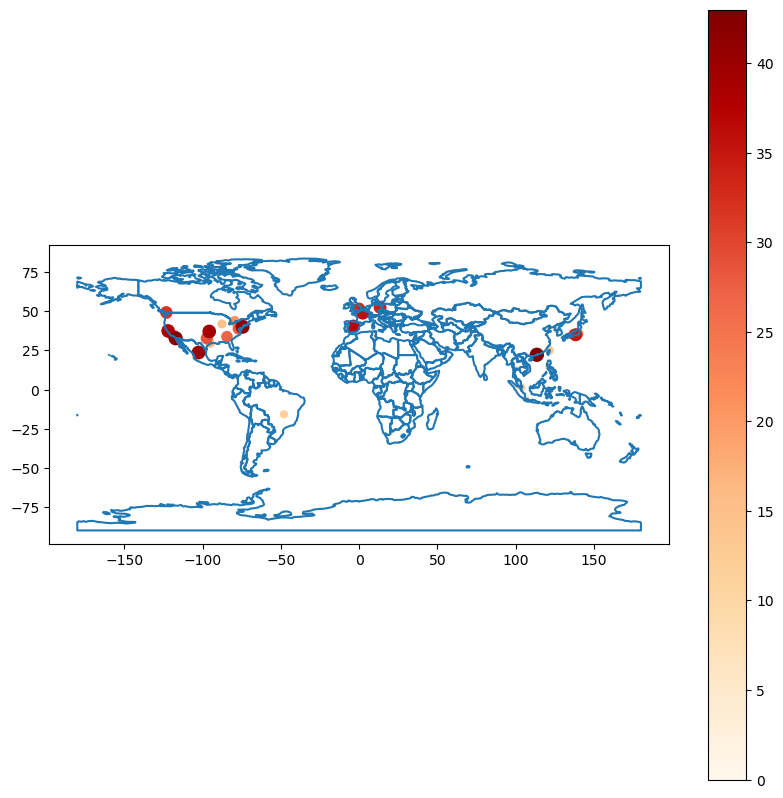

In [152]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(10, 10))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, column='出現次數', cmap='OrRd', markersize=gdf['出現次數']*2, legend=True)
plt.show()

# 圖表三

In [158]:
japan_data = {
    '福岡': 10,
    '埼玉': 9,
    '東京': 9,
    '大阪': 7,
    '神戶': 5,
    '橫濱': 5,
    '名古屋': 1,
    '靜岡': 1,
    '千葉': 1,
    '愛知': 1
}

In [159]:
japan_locations = {
    '福岡': {'lat': 33.5904, 'lon': 130.4017},
    '埼玉': {'lat': 35.8617, 'lon': 139.6452},
    '東京': {'lat': 35.6895, 'lon': 139.6917},
    '大阪': {'lat': 34.6937, 'lon': 135.5023},
    '神戶': {'lat': 34.6913, 'lon': 135.1830},
    '橫濱': {'lat': 35.4437, 'lon': 139.6380},
    '名古屋': {'lat': 35.1815, 'lon': 136.9066},
    '靜岡': {'lat': 34.9756, 'lon': 138.3828},
    '千葉': {'lat': 35.6073, 'lon': 140.1063},
    '愛知': {'lat': 35.1802, 'lon': 136.9066}
}

In [167]:
geometry = [Point(japan_locations[city]['lon'], japan_locations[city]['lat']) for city in japan_data]
gdf = gpd.GeoDataFrame(japan_data, geometry=geometry, columns=['出現次數'])
# 設置 '出現次數' 列
gdf['出現次數'] = gdf.index

print(gdf)

   出現次數                    geometry
0     0  POINT (130.40170 33.59040)
1     1  POINT (139.64520 35.86170)
2     2  POINT (139.69170 35.68950)
3     3  POINT (135.50230 34.69370)
4     4  POINT (135.18300 34.69130)
5     5  POINT (139.63800 35.44370)
6     6  POINT (136.90660 35.18150)
7     7  POINT (138.38280 34.97560)
8     8  POINT (140.10630 35.60730)
9     9  POINT (136.90660 35.18020)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21412\4089424585.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


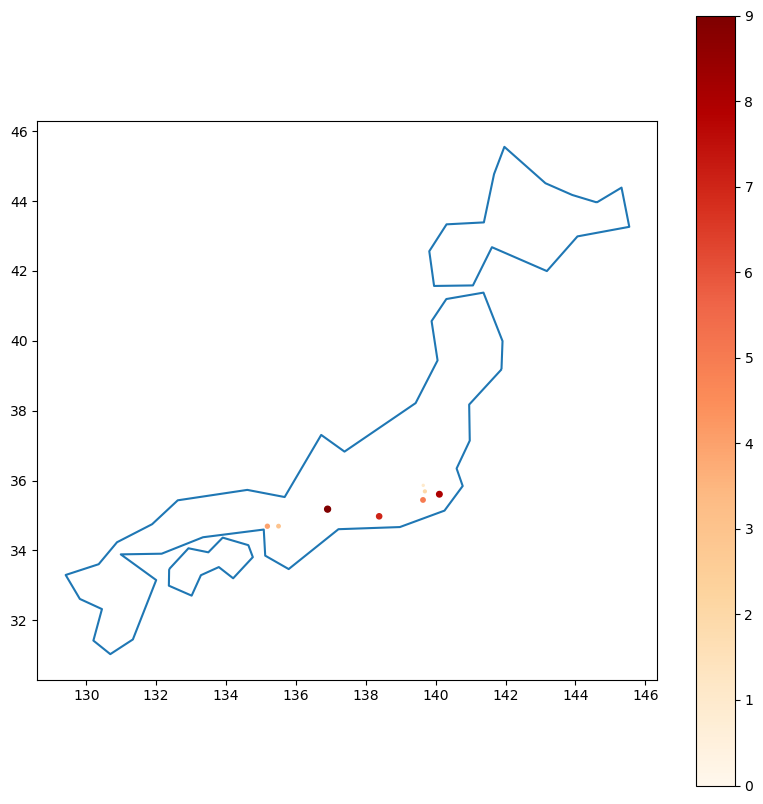

In [169]:
# 讀取世界地圖的資料
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 從世界地圖中選擇日本地區的資料
japan = world[world['name'] == 'Japan']

# 繪製日本地區的地圖
fig, ax = plt.subplots(figsize=(10, 10))
japan.boundary.plot(ax=ax)

gdf.plot(ax=ax, column='出現次數', cmap='OrRd', markersize=gdf['出現次數']*2, legend=True)

plt.show()